In [ ]:
#Este notebook se centra en el diseño de la red y en su entrenamiento.
#generator.next 
#Se podría probar a crear nuevas variables personalizadas que representasen la información del país, tal como la probabilidad de que 
#se exporte el producto, que surja una amenaza de X tipo, la amenaza más probable, etc.

## Librerías

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import splitfolders
import itertools
import keras 
import os

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPool2D
from keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from PIL import ImageFile

## Carga de los datos

In [3]:
#Cargamos los datos guardados del notebok anterior con el %store
#%store -r colores
#%store -r graph_labels
#%store -r y_guide
mirrored_strategy = tf.distribute.MirroredStrategy()
devices =  tf.config.experimental.list_physical_devices("GPU")

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


In [4]:
splitfolders.ratio("./Graph_Images/TRAIN/", output="./Graph_Images/data", seed = 1000, ratio = (.84, .16))

Copying files: 22220 files [00:39, 557.40 files/s]


In [5]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [11]:
TRAIN_DIR = './Graph_Images/data/train'
TEST_DIR = './Graph_Images/data/val'

width = 432
height = 288
batch_size = 15

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    validation_split = 0.19
)

test_datagen = ImageDataGenerator(
    rescale = 1./255,
)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(height, width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    subset='training') #set as training data.

validation_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(height, width),
    batch_size=5,
    class_mode='categorical',
    shuffle=True,
    subset='validation') #set as training data.

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size = (width,height),
    batch_size = 50,
    shuffle = False,
    class_mode = "categorical"
)

Found 15123 images belonging to 15 classes.
Found 3540 images belonging to 15 classes.
Found 3557 images belonging to 15 classes.


In [12]:
display(list(test_generator.class_indices.keys())   )

['adulteration or fraud',
 'allergens',
 'composition',
 'environmental pollutants',
 'food additives and flavourings',
 'foreign bodies',
 'metals',
 'microbial contaminants (other)',
 'migration',
 'mycotoxins',
 'packaging incorrect',
 'pathogenic micro-organisms',
 'pesticide residues',
 'poor or insufficient controls',
 'residues of veterinary medicinal products']

## Diseño de la red

In [13]:
with mirrored_strategy.scope():
    #CNNs
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(432,288,3))) # El ,3 es por ser RGB.
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(128, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(512, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    #MLP
    model.add(Dropout(0.2))
    model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
    model.add(Dense(256)) #Probar con más neuronas, 512.
    model.add(Activation('relu'))
    model.add(Dropout(0.1))
    model.add(Dense(32))
    model.add(Activation('relu'))
    
    model.add(Dense(15))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer= keras.optimizers.Adam(lr=0.0001),
                  metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 430, 286, 32)      896       
_________________________________________________________________
activation_7 (Activation)    (None, 430, 286, 32)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 215, 143, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 213, 141, 64)      18496     
_________________________________________________________________
activation_8 (Activation)    (None, 213, 141, 64)      0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 106, 70, 64)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 104, 68, 128)     

## Entrenamiento 

In [15]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch=2000 // batch_size,
        epochs=60,
        validation_data=validation_generator,
        validation_steps=800 // batch_size)
#model.save_weights('modelWeights.h5')  # always save your weights after training or during training

Epoch 1/60
133/133 [==============================] - 262s 2s/step - loss: 2.5656 - accuracy: 0.1815 - val_loss: 2.4880 - val_accuracy: 0.2340
Epoch 2/60
133/133 [==============================] - 262s 2s/step - loss: 2.3825 - accuracy: 0.2663 - val_loss: 2.4058 - val_accuracy: 0.1887
Epoch 3/60
133/133 [==============================] - 262s 2s/step - loss: 2.3028 - accuracy: 0.2832 - val_loss: 2.1967 - val_accuracy: 0.3245
Epoch 4/60
133/133 [==============================] - 263s 2s/step - loss: 2.2367 - accuracy: 0.2992 - val_loss: 2.2567 - val_accuracy: 0.2377
Epoch 5/60
133/133 [==============================] - 264s 2s/step - loss: 2.1943 - accuracy: 0.3168 - val_loss: 2.1523 - val_accuracy: 0.3245
Epoch 6/60
133/133 [==============================] - 261s 2s/step - loss: 2.1004 - accuracy: 0.3549 - val_loss: 2.0552 - val_accuracy: 0.3283
Epoch 7/60
133/133 [==============================] - 263s 2s/step - loss: 2.0770 - accuracy: 0.3649 - val_loss: 1.9798 - val_accuracy: 0.4226

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


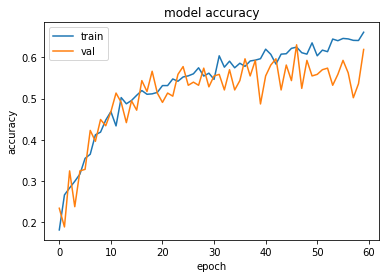

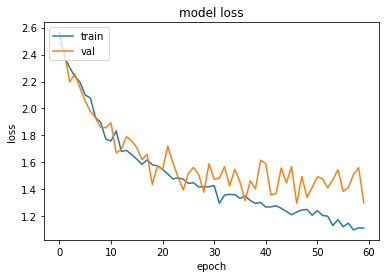

In [16]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
#plt.savefig('./accuracyTraining.png')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
#plt.savefig('./lossTraining.png')
plt.show()

In [17]:
test_metrics = model.evaluate(test_generator)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

72/72 [==============================] - 87s 1s/step - loss: 2.4178 - accuracy: 0.2418

Test Set Metrics:
	loss: 2.4178
	accuracy: 0.2418


In [19]:
n_batches = 2880 

true_classes = test_generator.classes

matrix = confusion_matrix(
    true_classes,    
    np.argmax(model.predict_generator(test_generator, steps=n_batches), axis=1) 
)

Instructions for updating:
Please use Model.predict, which supports generators.


In [20]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    #plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Confusion matrix, without normalization
[[ 37   1   1   1   3  16   0  22   9  49   6  27  30  24   6]
 [ 22   1   1   3  11  40   1   7   0  14  16  10  33  16   6]
 [ 26   1   3  18  11  16   1  15   1  13   5  21  75  28  38]
 [ 17   0   1  18   1   8   0   6   0   3   1  20  10  33   2]
 [ 15   3   0   0  29  35   4   6   0  46   8  37  49  35   5]
 [ 30   1   3   1   5  52   6  21   3  43  14  15  55  19   4]
 [ 12   0   0   1   4   3   5   6  76   6   6  25  20 104   4]
 [ 52   0   0   1   3  14  16  33   3  24  19  25  23  56   3]
 [ 23   0   0   0   0   1  30   1 168   0   1   0   0   0   0]
 [ 16   0   0   0  29  26   0  22   0 147   0  10  15   7   0]
 [ 14   0   0   2   3   5   2  14   6   7   8  19  17  21   5]
 [ 37   0   0   3   4  42   1  32   1  39   5  40  29  35   4]
 [  7   1   0   0  12  21   0   5   0  45   1  17 157   3   3]
 [ 27   0   0   6   1  12   3  13   0   8  10  24  10 114   1]
 [ 35   0   0   2   7  10   3  13   0  11  10  62   2  69  48]]


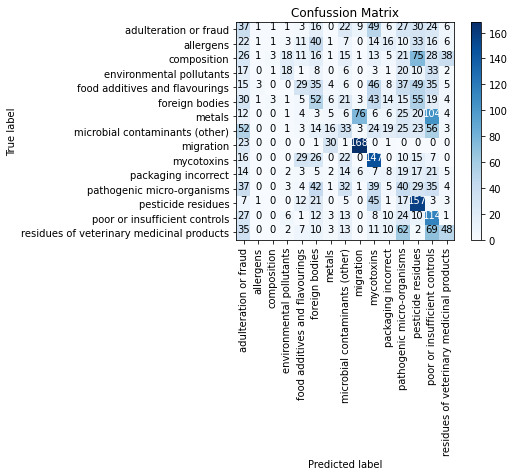

In [21]:
#labels = ["a","b","c","d","e","f","g","h","i","j","k","l","m","n","o","p","q"]
class_labels = list(test_generator.class_indices.keys())   


plot_confusion_matrix(matrix, class_labels, title="Confussion Matrix")

In [53]:
precision = np.zeros((len(matrix)))
especificidad = np.zeros((len(matrix)))
sensibilidad = np.zeros((len(matrix)))
miAccuracy = 0


sumaHorizontal = np.zeros((len(matrix)))
sumaVertical = np.zeros((len(matrix)))
sumaDiagonal = np.zeros((len(matrix)))

for i in range(len(sumaHorizontal)):
    sumaHorizontal[i] = matrix[i].sum() 
    
for i in range(len(sumaVertical)):
    for j in range(len(sumaVertical)):
        sumaVertical[i] += matrix[j][i]
    
for i in range(len(sumaDiagonal)):
    sumaDiagonal[i] = matrix[i][i]
    
display(sumaHorizontal)
display(sumaVertical)
display(sumaDiagonal)

for i in range(len(precision)):
    precision[i] = matrix[i][i]/sumaVertical[i]
    
for i in range(len(sensibilidad)):
    sensibilidad[i] = matrix[i][i]/sumaHorizontal[i]
    
for i in range(len(especificidad)):
    especificidad[i] = (sumaDiagonal[:i].sum()+sumaDiagonal[(i+1):].sum())/(sumaHorizontal[:i].sum()+sumaHorizontal[(i+1):].sum())
    
miAccuracy = sumaDiagonal.sum()/sumaHorizontal.sum()
print("")
print("")
print("Métricas de la Matriz de Confusión:")
print("")
print("Accuracy:",miAccuracy)
print("--------------------------------")
print("Precision de la clase:",precision)
print("--------------------------------")
print("Sensibilidad:",sensibilidad)
print("--------------------------------")
print("Especificidad:",especificidad)
print("--------------------------------")


array([232., 181., 272., 120., 272., 272., 272., 272., 224., 272., 123.,
       272., 272., 229., 272.])

array([370.,   8.,   9.,  56., 123., 301.,  72., 216., 267., 455., 110.,
       352., 525., 564., 129.])

array([ 37.,   1.,   3.,  18.,  29.,  52.,   5.,  33., 168., 147.,   8.,
        40., 157., 114.,  48.])



Métricas de la Matriz de Confusión:

Accuracy: 0.2417767781838628
--------------------------------
Precision de la clase: [0.1        0.125      0.33333333 0.32142857 0.23577236 0.17275748
 0.06944444 0.15277778 0.62921348 0.32307692 0.07272727 0.11363636
 0.29904762 0.20212766 0.37209302]
--------------------------------
Sensibilidad: [0.15948276 0.00552486 0.01102941 0.15       0.10661765 0.19117647
 0.01838235 0.12132353 0.75       0.54044118 0.06504065 0.14705882
 0.57720588 0.49781659 0.17647059]
--------------------------------
Especificidad: [0.2475188  0.25444313 0.2608828  0.24498109 0.25296804 0.24596651
 0.26027397 0.25175038 0.20762076 0.21704718 0.24810716 0.24961948
 0.21400304 0.22415865 0.24718417]
--------------------------------
